## Predicting Recurrence/Non-Recurrence in Breast Cancer

In [2]:
# Basic 
import pandas as pd
import numpy as np
import pickle

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.decomposition import PCA

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Read in Dataset

In [47]:
# Dataset Filepaths: 
big_NR = "../data/large_transformed_cancer_dataset.pandas"
big_NC = "../data/large_transformed_dataset.pandas"
big_NR_mod = "../data/big_transformed_mod_cancer_dataset.pandas"
pr_NR = "../data/prior_transformed_cancer_dataset.pandas"
pr_NC = "../data/prior_transformed_dataset.pandas"
ak_NC = "../data/prior_wgcnaAK_dataset.pandas"
ak_NC_mod = "../data/prior_wgcnaAK_mod_dataset.pandas"

with open(pr_NR, 'rb') as f: 
    df_data = pickle.load(f)

# df_data

In [41]:
metadata = pd.read_csv("../data/metadata.csv")
status = metadata.recurStatus.values
y_true = []
# Recurrent vs. Non-recurrent 
for c in status: 
    if c == 'R': 
        y_true.append(1)
    elif c == "N": 
        y_true.append(0)

# For cancer vs. non-cancer
# for c in status: 
#     if c == "R" or c == "N": 
#         y_true.append(1)
#     else:
#         y_true.append(0)

In [48]:
X = df_data.values
y = y_true

## Zach stuff

### Read in cancer data and metadata

In [98]:
cancer = pd.read_csv("data/GSE131512_cancerTPM.txt", sep = '\t')
metadata = pd.read_csv("data/metadata.csv")

In [99]:
cancer.shape

(60675, 96)

In [100]:
metadata.shape

(128, 10)

### Map each ENSG ID to Gene IDs

In [101]:
ens_to_sym = pd.read_csv("data/ensembl_to_symbol.txt", sep = '\t')
ens_to_sym = ens_to_sym.dropna()
ens_to_sym = dict(zip(ens_to_sym.Ensembl, ens_to_sym.Symbol))
keep = set(list(cancer.index)).intersection(set(ens_to_sym.keys()))
ens_to_sym = {k: ens_to_sym[k] for k in keep}
cancer = cancer[cancer.index.isin(ens_to_sym.keys())]
cancer = cancer.rename(index=ens_to_sym)
cancer.shape

(41355, 96)

In [102]:
cancer.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
TSPAN6,7.071605,60.610797,58.255903,29.917356,24.500322,25.311091,37.394452,15.354658,24.839014,24.591295,...,14.134044,10.803910,6.068982,12.714350,15.983392,0.000000,38.189128,15.608352,51.519267,30.805593
TNMD,13.279391,47.424080,60.455497,6.482332,53.675826,31.686900,32.409716,0.000000,48.976056,46.178684,...,0.000000,12.172853,136.759411,28.650721,0.000000,0.000000,5.976111,6.280734,241.863225,0.000000
DPM1,0.000000,0.000000,23.040206,8.646690,20.456404,42.266702,21.615428,11.538256,18.665274,76.996356,...,79.657691,8.118597,0.000000,0.000000,0.000000,179.178412,15.942897,0.000000,0.000000,0.000000
SCYL3,6.212355,2.218590,12.120963,6.065120,16.142519,37.059356,7.580945,0.000000,0.000000,21.603278,...,18.624986,15.660412,33.988677,0.000000,36.858404,83.788404,18.172309,2.938248,14.547636,10.148436
FIRRM,34.038592,35.828348,55.926653,10.494273,14.482668,19.236768,13.117055,4.667898,18.877984,12.459809,...,17.903438,19.706680,23.062537,1.932615,28.344382,3.020339,27.411791,1.694651,3.729079,7.804221


### Filter for the Prior Association Genes

In [103]:
prior = "data/prior_association.txt"
with open(prior) as data:
    lines = [line.rstrip() for line in data]
prior = lines[0]
prior = prior.split(", ")
prior = list(set(prior))
cancer = cancer[cancer.index.isin(prior)]
cancer = cancer.transpose()
scaler = StandardScaler()
cancer = scaler.fit_transform(cancer)
status = list(metadata["recurStatus"])
binary = []
for c in status:
    if c == "R":
        binary.append(1)
    elif c == "N":
        binary.append(0)
X = cancer
y = binary

## Modeling

Explore some models, such as SVM, Logistic Regression, Random Forest Classifier, and Gradient Boosted Classifier

### SVM

Average AUROC with 10-fold CV: 0.38095238095238093


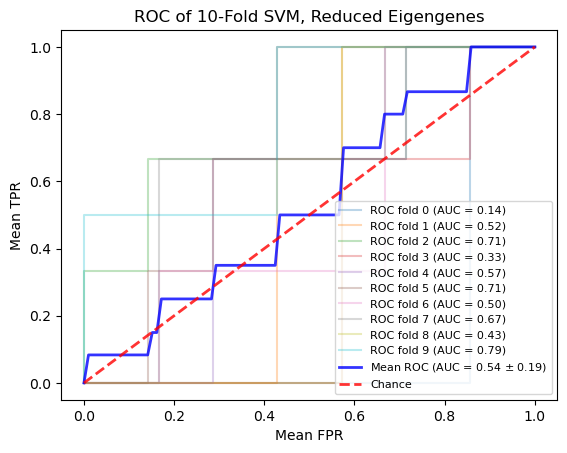

In [49]:
clf = SVC(C = 10, probability=True)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
roc(X, y, model = clf, model_name = "SVM")

### Logistic Regression

Average AUROC with 10-fold CV: 0.28174603174603174


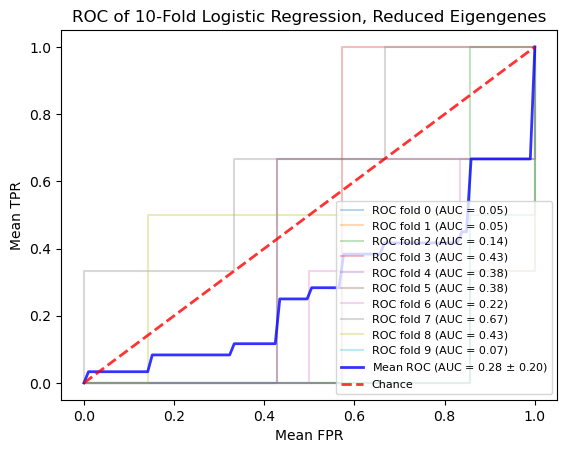

In [50]:
clf = LogisticRegression(C = 6, max_iter = 10000)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
roc(X, y, model = clf, model_name = "Logistic Regression")

### Random Forest

Average AUROC with 10-fold CV: 0.4603174603174603


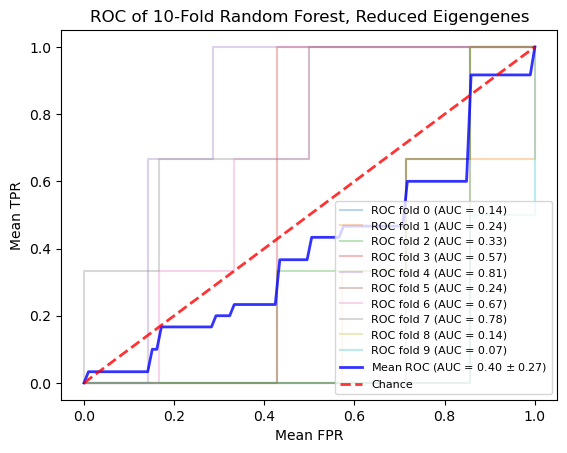

In [51]:
clf = RandomForestClassifier(max_depth = 5)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
roc(X, y, model = clf, model_name = "Random Forest")

### Gradient Boosted Tree

Average AUROC with 10-fold CV: 0.3388888888888889


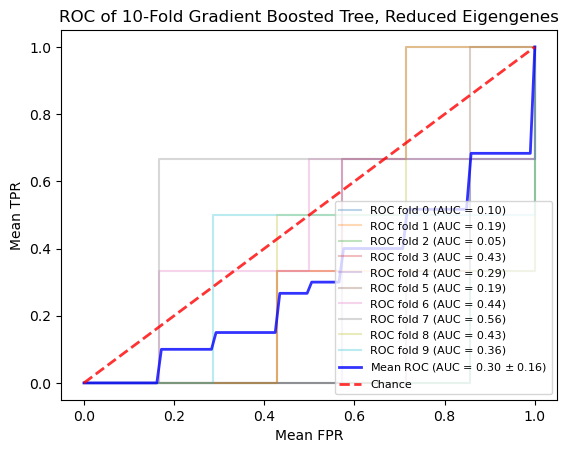

In [52]:
clf = GradientBoostingClassifier(n_estimators = 50)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
roc(X, y, model = clf, model_name = "Gradient Boosted Tree")

### Elastic Net

In [11]:
clf = LogisticRegression(C = 6, max_iter = 10000, penalty="elasticnet", solver='saga', l1_ratio=0.5)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())

Average AUROC with 10-fold CV: 0.4984126984126984


### To Do: Evaluate models with tuned hyperparameters and different fold cross validations.  Also evaluate models on subsets of the features

In [31]:
def roc(X, y, model, model_name):
    
    y = label_binarize(y, classes=[0, 1])
    n_classes = y.shape[1]

    # Create a cross-validation strategy
    cv = StratifiedKFold(n_splits=10)

    # Classifier
    clf = model

    # Variables to collect results
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y.ravel())):
        # Train the model
        clf.fit(X[train], y[train].ravel())
        # Predict probabilities
        y_proba = clf.predict_proba(X[test])
    
        # Compute ROC curve and area the curve
        fpr, tpr, _ = roc_curve(y[test].ravel(), y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    
        # Plotting each fold
        ax.plot(fpr, tpr, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the average ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    # Plot luck line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    # Set graph labels and legend
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"ROC of 10-Fold {model_name}, Reduced Eigengenes")
    ax.set_xlabel("Mean FPR")
    ax.set_ylabel("Mean TPR")
    ax.legend(loc="lower right", prop={'size': 8})
    plt.show()

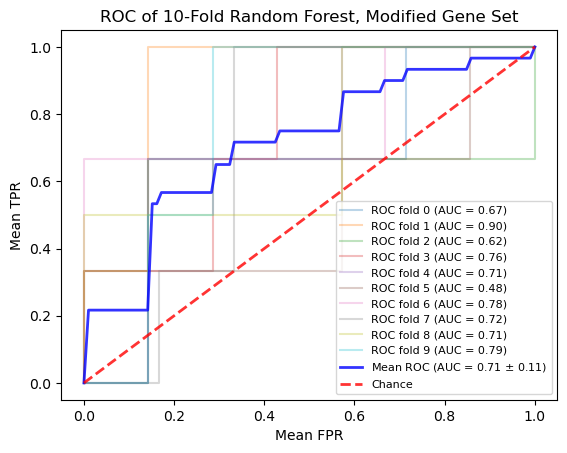

In [22]:
roc(X, y, model = "Random Forest")